    Importing Dependencies

In [144]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize
import yfinance as yf
import plotly.graph_objects as go
import plotly.express as px
import matplotlib.pyplot as plt
from scipy.stats import norm

    Input of Stocks in the Portfolio

In [145]:
custom_stocks = []

number_stocks = int(input("Nummber of Stocks: "))

for i in range(number_stocks):
    input_stocks = input("Your stockss: ")

    custom_stocks.append(input_stocks)

select = custom_stocks
country_code = ''
##

##
start = '2017-01-01'
end = '2023-10-27'
N_years = 6
riskfree = 0.049
##

max_allocations = 100
bound = (0, max_allocations/100)

cash_percent = 0

benchmark = '^GSPC'

    Raw Data

In [146]:
### Data for stocks

stocks =  []

for i in select:
    stocks.append((i))
    
def listtostring(s):
    str1 = ','
    return (str1.join(s))

tickers_list = [tickers + country_code for tickers in select]
stocks_string = listtostring(tickers_list)

data_stocks = yf.download(stocks_string, start, end)['Close']

## Benchmark Data

ticker_benchmark = yf.Ticker(benchmark)

data_benchmark = yf.download(benchmark, start, end)['Close']
beta_pct = data_benchmark.pct_change()

[*********************100%%**********************]  4 of 4 completed
[*********************100%%**********************]  1 of 1 completed


    Basic Calculations
- Historic Returns
- Benchmark Returns
- Covariance Matrix
- Benchmark Value at Risk
- Expected Returns using CAPM

In [147]:
pct_return_stock = data_stocks.pct_change()
pct_return_benchmark = data_benchmark.pct_change()

def HistoricR(a):
    return np.product(1+a)**(1/N_years) - 1

historic_r_stocks = HistoricR(pct_return_stock)    
historic_r_benchmark = HistoricR(pct_return_benchmark)

Covariance = pct_return_stock.cov()
benchmark_var = pct_return_benchmark.var()

weights = np.ones(len(historic_r_stocks))/len(historic_r_stocks)
    
### Portfolio Calculations

return_port = np.sum(weights*historic_r_stocks)
risk_port = np.sqrt(np.matmul(weights, np.matmul(Covariance,weights.T))*(252))

beta_stocks = stocks_string + ',' + benchmark
data = yf.download(beta_stocks, start, end)['Close'].pct_change()

cov = data.cov()
var = data[benchmark].var()

beta = cov.loc[benchmark]/var
beta_i_stocks = beta[:-1]

expected_return = (riskfree + beta_i_stocks*(historic_r_benchmark - riskfree))

[*********************100%%**********************]  5 of 5 completed


In [148]:
input_returns  = expected_return

    Maximising Sharpe Ratio
- This algorithm adjusts the allocation of stocks in such a way that the Sharpe Ratio of the overall portfolio is maximised.

In [149]:
## defining negative sharpe ratio

def negativeSharpe(weights, riskfree):
    
    return_port = np.sum(weights*input_returns)
    risk_port = np.sqrt(np.matmul(weights, np.matmul(Covariance,weights.T))*(252))

    return -(return_port - riskfree)/risk_port

# defining the sum of weights

def sumone(weights):
    return np.sum(weights)

args_sharpe  = riskfree
bnds_sharpe = tuple(bound for stocks in range(len(input_returns)))
cons_sharpe = ({'type': 'eq', 'fun': lambda x: sumone(x) - (1 - cash_percent/100)})

opt_sharpe = minimize(negativeSharpe, weights, args= args_sharpe, 
                        bounds= bnds_sharpe, constraints= cons_sharpe, method='SLSQP')

opt_weights_shape = opt_sharpe['x']

print('Maximum Sharpe Ratio')
print((1-(cash_percent/100)-0.001)<np.sum(opt_weights_shape)<(1-(cash_percent/100)+0.001))
print('')
print('For Max Sharpe =', np.round(-opt_sharpe['fun'],3))
print('')

sharpe_table = {
    'Stocks': tickers_list,
    'Allocation(%)': np.round(opt_weights_shape*100,2)
}

df_sharpe = pd.DataFrame(sharpe_table)
df_weight_sharpe = df_sharpe.sort_values( by = ['Allocation(%)'], ascending = False)

print(df_weight_sharpe)

Maximum Sharpe Ratio
True

For Max Sharpe = 0.267

  Stocks  Allocation(%)
0   AAPL          40.69
2      F          29.32
3    WMT          17.69
1     GS          12.30


    Maximum Return on Minimum Risk
- Optimises the allocation of stocks in the portfolio for Minimum Risk possible for all the combinations.

In [150]:
# Defining the portfolio risk

def risk(weights, Covariance):
    return np.sqrt(np.matmul(weights, np.matmul(Covariance, weights.T))*252)

args_minrisk = Covariance
bnds_minrisk = tuple(bound for stocks in range (len(input_returns)))
cons_minrisk = ({'type': 'eq', 'fun': lambda x: sumone(x) - (1-cash_percent/100)})

# Minimising the risk to Max

min_risk = minimize(risk, weights, args=args_minrisk, bounds= bnds_minrisk, constraints= cons_minrisk, method='SLSQP')
min_risk_weights = min_risk['x']

min_risk_return = np.sum(min_risk_weights*input_returns)

print('Minimum Risk Possible')
print((1-(cash_percent/100)-0.001)<np.sum(opt_weights_shape)<(1-(cash_percent/100)+0.001))
print ('For Minimum RISK possible (%) =', np.round(min_risk['fun']*100,2))
print ('RETURN on min RISK (%) =', np.round(min_risk_return*100,2))
print('')

minrisk_table = {
    'Stocks': tickers_list,
    'Allocation(%)': np.round(min_risk_weights*100,2)
}

df_minrisk = pd.DataFrame(minrisk_table)
df_weight_minrisk = df_minrisk.sort_values(by = ['Allocation(%)'], ascending = False)

print(df_weight_minrisk)

Minimum Risk Possible
True
For Minimum RISK possible (%) = 19.3
RETURN on min RISK (%) = 9.22

  Stocks  Allocation(%)
3    WMT          63.32
2      F          15.75
0   AAPL          12.86
1     GS           8.07


    Maximising Return on Given Risk
- Maximises the Return on Risk taken as Input from the User 

In [151]:
target_risk = 0.20

def returns(weights, input_returns):
    return -np.sum(weights*input_returns)

def risk(weights, Covariance):
    return np.sqrt(np.matmul(weights, np.matmul(Covariance, weights.T))*252)

args_maxreturn = input_returns
bnds_maxreturn = tuple(bound for stocks in range(len(input_returns)))
cons_maxreturn = ({'type': 'eq', 'fun': lambda x: sumone(x) - (1-cash_percent/100)},
                    {'type': 'eq', 'fun': lambda y: risk(y, Covariance) - (target_risk)})

opt_maxreturn = minimize (returns, weights, args=args_maxreturn, bounds=bnds_maxreturn, constraints=cons_maxreturn, method='SLSQP')

mrgr_weights = (opt_maxreturn['x'])
mrgr_return = opt_maxreturn['fun']
mrgr_risk = np.sqrt(np.matmul(mrgr_weights, np.matmul(Covariance, mrgr_weights.T))*252)

print('Maximising Return on Given Risk')
print((1-(cash_percent/100)-0.001)<np.sum(mrgr_weights)<(1-(cash_percent/100)+0.001))
print (target_risk-0.001<mrgr_risk<target_risk+0.001)
print ('For Given risk (%) =', target_risk*100)
print('')

mrgr_table = {
    'Stocks': tickers_list,
    'Allocation(%)': np.round(mrgr_weights*100,2)
}
df_mrgr = pd.DataFrame(mrgr_table)
df_weight_mrgr = df_mrgr.sort_values(by = ['Allocation(%)'], ascending = False)

print(df_weight_mrgr)

Maximising Return on Given Risk
True
True
For Given risk (%) = 20.0

  Stocks  Allocation(%)
3    WMT          44.18
0   AAPL          24.64
2      F          21.43
1     GS           9.75


    Random Simulation
- Simulates 1 million different portfolios with random allocation to all the stocks to see the Risk Return curve

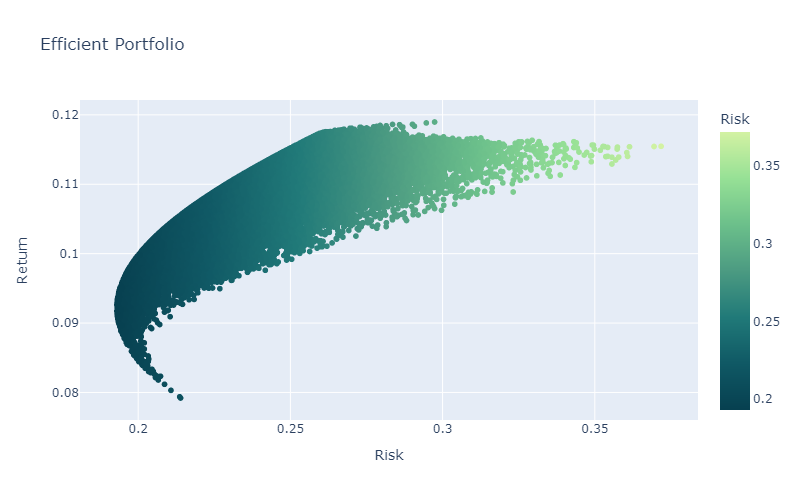

In [153]:
num_portfolios = 100000

# Defining random weights

f_rand_returns = []
f_rand_risk = []

for i in range(num_portfolios):

    randomness = np.random.random(len(weights))
    randomness_sum = np.sum(randomness)
    random_weights = randomness/randomness_sum  

    rand_returns = np.sum(random_weights*input_returns)
    rand_risk = np.sqrt(np.matmul(random_weights, np.matmul(Covariance, np.transpose(random_weights)))*252)

    f_rand_returns.append(rand_returns)
    f_rand_risk.append(rand_risk)

df_random = pd.DataFrame({
    'Risk': f_rand_risk,
    "Return": f_rand_returns
})
plot = px.scatter(df_random, x = 'Risk', y = 'Return', title = 'Efficient Portfolio', 
                    color = 'Risk', width = 800, height= 500, 
                    color_continuous_scale=px.colors.sequential.Emrld_r
        )
plot.show("png")